In [1]:
import pandas as pd
from src.parsing import parse_GO
from src.data_load import Dataset
import os
from Bio.Seq import Seq
from Bio import SeqIO
import matplotlib.pyplot as plt
from src.data_load import fetch_taxa

Paths for data files below

In [2]:
TRAIN_ROOT = "./Data/cafa5protein/Train/"
go_path = os.path.join(TRAIN_ROOT, "go-basic.obo")
train_sequences_path = os.path.join(TRAIN_ROOT, "train_sequences.fasta")
train_taxonomy_path = os.path.join(TRAIN_ROOT, "train_taxonomy.tsv")
train_terms_path = os.path.join(TRAIN_ROOT, "train_terms.tsv")

In [3]:
"""Get data files"""
go_terms = parse_GO(go_path)

In [4]:
fasta_sequences = SeqIO.parse(open(train_sequences_path),'fasta')
fastas = []
for fasta in fasta_sequences:
     fastas.append({"id": fasta.id, "seq": fasta})

In [5]:
train_data = Dataset(pd.DataFrame(fastas), 
                     pd.read_csv(train_taxonomy_path, sep="\t"), 
                     pd.read_csv(train_terms_path, sep="\t"))

In [6]:
train_data.taxonomy.head()

,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431


In train taxonomy, start with checking the number of unique entryIDs, unique taxonomyIDs, and then total number of entries.

In [7]:
print("Number of EntryIDS: {}".format(len(train_data.taxonomy["EntryID"].unique())))
print("Number of taxonomic IDS: {}".format(len(train_data.taxonomy["taxonomyID"].unique())))
print("Total Length: {}".format(len(train_data.taxonomy)))

Number of EntryIDS: 142246
Number of taxonomic IDS: 3156
Total Length: 142246


Check for overrepresented taxa.

In [8]:
taxa = fetch_taxa(train_data.taxonomy["taxonomyID"].to_list())

In [15]:
taxa.columns = ["taxonomyID"] + taxa.columns.tolist()[1:]


In [52]:
taxa.drop_duplicates(subset=["taxonomyID"], inplace=True, keep="first")

In [26]:
"""Merge taxa with taxonomic ids from train dataset"""
df_train_taxa_full = train_data.taxonomy.merge(taxa, how="left", on="taxonomyID")
"""Verify length and number of unique taxa"""
print("Length of new: {}".format(len(df_train_taxa_full))) #Needs to match original length

Length of new: 142246


In [27]:
df_train_taxa_full.head()

,EntryID,taxonomyID,ScientificName,Rank,Division,GeneticCode,MitoGeneticCode,CreateDate
0,Q8IXT2,9606,Homo sapiens,species,Primates,"{'GCId': '1', 'GCName': 'Standard'}","{'MGCId': '2', 'MGCName': 'Vertebrate Mitochon...",1995/02/27 09:24:00
1,Q04418,559292,Saccharomyces cerevisiae S288C,strain,Plants and Fungi,"{'GCId': '1', 'GCName': 'Standard'}","{'MGCId': '3', 'MGCName': 'Yeast Mitochondrial'}",2008/09/09 16:05:46
2,A8DYA3,7227,Drosophila melanogaster,species,Invertebrates,"{'GCId': '1', 'GCName': 'Standard'}","{'MGCId': '5', 'MGCName': 'Invertebrate Mitoch...",1995/02/27 09:24:00
3,Q9UUI3,284812,Schizosaccharomyces pombe 972h-,strain,Plants and Fungi,"{'GCId': '1', 'GCName': 'Standard'}","{'MGCId': '4', 'MGCName': 'Mold Mitochondrial;...",2004/07/12 13:31:11
4,Q57ZS4,185431,Trypanosoma brucei brucei TREU927,strain,Invertebrates,"{'GCId': '1', 'GCName': 'Standard'}","{'MGCId': '4', 'MGCName': 'Mold Mitochondrial;...",2002/01/28 08:53:00


<AxesSubplot:>

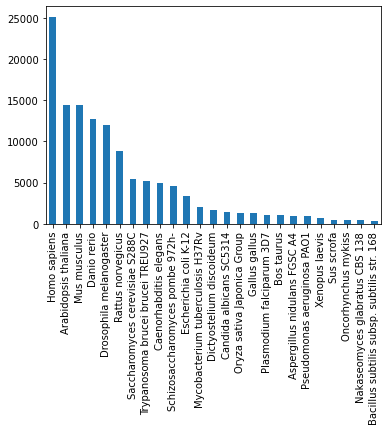

In [36]:
df_train_taxa_full["ScientificName"].value_counts()[0:25].plot(kind="bar")

Now get details on the count of overrepresented taxa as well as overrepresented divisions.

In [28]:
df_train_taxa_full["Division"].value_counts()

Plants and Fungi    31982
Invertebrates       25936
Primates            25192
Rodents             23361
Vertebrates         15887
Bacteria            11002
Mammals              2029
Viruses               661
Phages                213
Name: Division, dtype: int64

In [37]:
#Look at TaxID as percent of total
represented_taxID = df_train_taxa_full["ScientificName"].value_counts()/len(df_train_taxa_full)
print(represented_taxID)

Homo sapiens                            0.176631
Arabidopsis thaliana                    0.101662
Mus musculus                            0.101121
Danio rerio                             0.089078
Drosophila melanogaster                 0.084501
                                          ...   
Colletotrichum gloeosporioides Cg-14    0.000007
Psilocybe cyanescens                    0.000007
Cryptosporidium parvum                  0.000007
Yellow fever virus 17D                  0.000007
Bacillus sp. GL1                        0.000007
Name: ScientificName, Length: 626, dtype: float64


<AxesSubplot:>

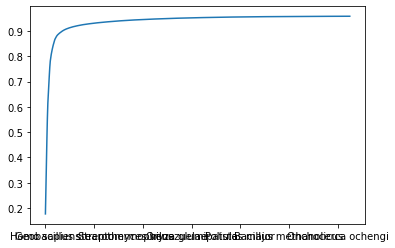

In [38]:
"""Plot cumutively to see when it begins to plateu"""
represented_taxID.cumsum().plot()

#mask = df_train_taxa_full["taxonomyID"].isin(represented_taxID.index.tolist()[0:499])
#top500_represented_taxID = df_train_taxa_full[mask]

In [53]:
top_represented = represented_taxID[represented_taxID.cumsum()<0.91]
print(top_represented)

Homo sapiens                                                        0.176631
Arabidopsis thaliana                                                0.101662
Mus musculus                                                        0.101121
Danio rerio                                                         0.089078
Drosophila melanogaster                                             0.084501
Rattus norvegicus                                                   0.061984
Saccharomyces cerevisiae S288C                                      0.038447
Trypanosoma brucei brucei TREU927                                   0.036620
Caenorhabditis elegans                                              0.034553
Schizosaccharomyces pombe 972h-                                     0.032577
Escherichia coli K-12                                               0.023916
Mycobacterium tuberculosis H37Rv                                    0.014496
Dictyostelium discoideum                                            0.011993

The top 500 taxa appear to span the representative divisions well. 

POSSIBLE APPROACH: Look for orthologous proteins across either division or taxa using blast. If an orthologous protein is found - group training method by incoroporating a voting system on the result.

Next lets look at training terms.

In [39]:
train_data.terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [40]:
train_data.terms["aspect"].value_counts()

BPO    3497732
CCO    1196017
MFO     670114
Name: aspect, dtype: int64

In [41]:
train_data.terms["term"].value_counts()

GO:0005575    92912
GO:0008150    92210
GO:0110165    91286
GO:0003674    78637
GO:0005622    70785
              ...  
GO:0031772        1
GO:0042324        1
GO:0031771        1
GO:0051041        1
GO:0102628        1
Name: term, Length: 31466, dtype: int64

In [45]:
train_data.terms["EntryID"].value_counts()

Q02248    815
Q62226    736
Q01705    721
P22725    709
P01137    668
         ... 
P52377      2
Q51912      2
A2IBF8      2
A2IBF9      2
F1R8A4      2
Name: EntryID, Length: 142246, dtype: int64

In [55]:
terms_cum = train_data.terms["term"].value_counts().cumsum()/len(train_data.terms)

In [58]:
top_selected_terms = terms_cum[terms_cum<0.9]

In [59]:
print(len(top_selected_terms))

3092


<AxesSubplot:>

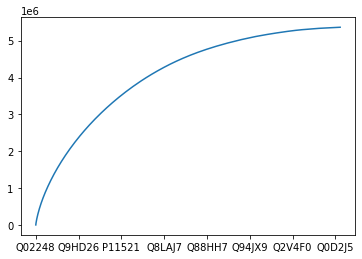

In [47]:
train_data.terms["EntryID"].value_counts().cumsum().plot()